### 1. Library Imports

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score

<ipython-input-1-a10f47492a9e>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
<ipython-input-1-a10f47492a9e>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


### 2. Data Generation

In [2]:
rng = np.random.default_rng(seed=42)
raw_data = rng.random(20000)
raw_data[0:10000]
X_data = raw_data[0:10000] * 3 - 1.5
Y_data = raw_data[10000:20000] * 2 - 1
label = (X_data**2 * (np.sin(3*X_data))**10 + Y_data**2 < 0.4).astype(int)

print(X_data)
print(Y_data)
print(label)

[ 0.82186815 -0.18336468  1.07579376 ... -1.0039591  -0.37976881
 -0.05727668]
[ 0.44145677  0.42247552 -0.59460994 ...  0.69426214  0.34160649
 -0.71747991]
[1 1 1 ... 0 1 0]


### 3. Data Plotting

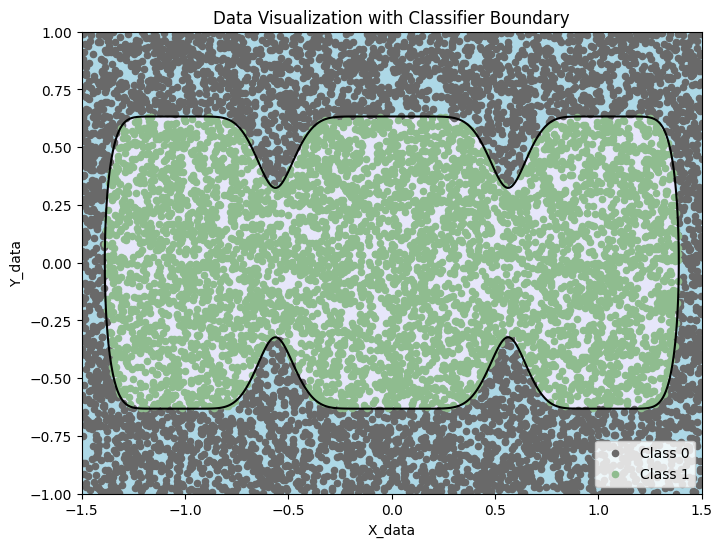

In [3]:
x_vals = np.linspace(-1.5, 1.5, 400)
y_vals = np.linspace(-1, 1, 400)
X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
Z_mesh = X_mesh**2 * (np.sin(3*X_mesh))**10 + Y_mesh**2

plt.figure(figsize=(8, 6))
plt.contourf(X_mesh, Y_mesh, Z_mesh < 0.4, levels=1, colors=['lightblue', 'lavender'])
plt.contour(X_mesh, Y_mesh, Z_mesh - 0.4, levels=[0], colors='black', linewidths=1.5)
plt.scatter(X_data[label == 0], Y_data[label == 0], c='dimgray', label="Class 0", s=20)
plt.scatter(X_data[label == 1], Y_data[label == 1], c='darkseagreen', label="Class 1", s=20)
plt.xlabel("X_data")
plt.ylabel("Y_data")
plt.title("Data Visualization with Classifier Boundary")
plt.legend()
plt.show()

### 4. Utility Functions

In [4]:
# This function is borrowed from classwork notebook Week 3
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [5]:
# This function is borrowed from classwork notebook Week 3
def run_epoch(model, optimizer, data_loader, loss_func, device,
              results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()

    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device).unsqueeze(1)

        y_hat = model(inputs)  # Forward pass
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        running_loss.append(loss.item())

        if len(score_funcs) > 0:
            labels = labels.detach().cpu().numpy()
            y_hat = (y_hat.detach().cpu().numpy() > 0.5).astype(int)
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())

    end = time.time()

    results[prefix + " loss"].append(np.mean(running_loss))
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append(score_func(y_true, y_pred))
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end - start

In [6]:
# This function is borrowed from classwork notebook Week 3
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=20, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score)
        if test_loader is not None:
            to_track.append("test " + eval_score)

    total_train_time = 0
    results = {item: [] for item in to_track}

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func,
                                      device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append(total_train_time)
        results["epoch"].append(epoch)

        if test_loader is not None:
            model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device,
                          results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results': results
        }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

### 5. Train/Test Data

In [7]:
batch_size = 32
feature_tensor = torch.tensor(np.column_stack((X_data, Y_data)), dtype=torch.float32)
label_tensor = torch.tensor(label, dtype=torch.float32)

generator = torch.Generator().manual_seed(52)
dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor)
train_ds, test_ds = random_split(dataset, [0.7, 0.3], generator)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
print(f"Training samples: {len(train_ds)}")
print(f"Testing samples: {len(test_ds)}")

Training samples: 7000
Testing samples: 3000


### 6. Model Architecture

In [9]:
model = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

loss_func = nn.BCELoss()

results_df = train_simple_network(
    model,
    loss_func,
    train_loader,
    epochs=100,
    device="cpu",
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score, 'F1': f1_score}
)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Testing:   0%|          | 0/94 [00:00<?, ?it/s]

In [10]:
print(f"Final Test Accuracy: {results_df['test Accuracy'].iloc[-1] * 100:.4f}%")

Final Test Accuracy: 95.9333%
